## ShowsSpenders

**Author:** Anthony Tian

**Loan Risk Profiling Project**

**Driving Question:** How can credit default be predicted, using historical payment behavior and borrower characteristics?

**Goal:** Experiment w all things that go into ML models, while classifying clients' defaulting likelihoods on next cc pmt.

**Dataset:** [UCI Credit Card Default](https://www.openml.org/search?type=data&sort=runs&id=42477&status=active)

In [81]:
# core
import numpy as np
import pandas as pd
import warnings

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

# ml
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, roc_auc_score, ConfusionMatrixDisplay
import optuna
import shap
from xgboost import XGBClassifier
import xgboost as xgb


# other
from scipy.io import arff
from imblearn.over_sampling import SMOTE

In [4]:
warnings.filterwarnings('ignore')

**Data**

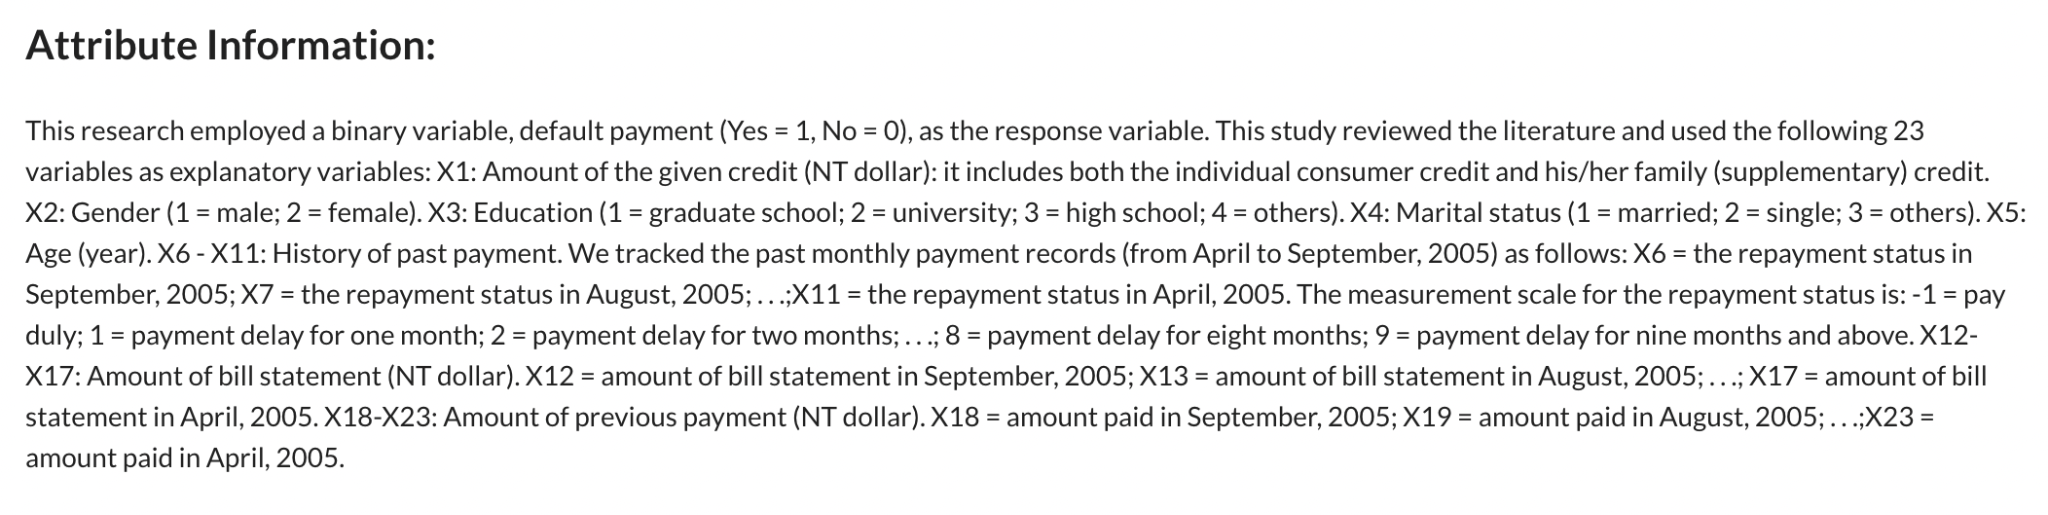

In [6]:
col_guide_img = Image.open('col_guide_img.png')
display(col_guide_img)
# straight from OpenML source:

In [7]:
data, meta = arff.loadarff('default of credit card clients.arff')
df = pd.DataFrame(data)
for col in df.select_dtypes(['object']):
    df[col] = df[col].str.decode('utf-8')
df.to_csv('credit_default.csv', index=False)

In [8]:
df

,id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,y
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996.0,220000.0,1.0,3.0,1.0,39.0,0.0,0.0,0.0,0.0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997.0,150000.0,1.0,3.0,2.0,43.0,-1.0,-1.0,-1.0,-1.0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998.0,30000.0,1.0,2.0,2.0,37.0,4.0,3.0,2.0,-1.0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999.0,80000.0,1.0,3.0,1.0,41.0,1.0,-1.0,0.0,0.0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [9]:
df.columns = [
    'id',
    'limit_bal',      # X1
    'sex',            # X2
    'education',      # X3
    'marriage',       # X4
    'age',            # X5
    'pay_sep',        # X6
    'pay_aug',        # X7
    'pay_jul',        # X8
    'pay_jun',        # X9
    'pay_may',        # X10
    'pay_apr',        # X11
    'bill_sep',       # X12
    'bill_aug',       # X13
    'bill_jul',       # X14
    'bill_jun',       # X15
    'bill_may',       # X16
    'bill_apr',       # X17
    'pay_amt_sep',    # X18
    'pay_amt_aug',    # X19
    'pay_amt_jul',    # X20
    'pay_amt_jun',    # X21
    'pay_amt_may',    # X22
    'pay_amt_apr',    # X23
    'default'         # y
]

In [10]:
df.head()

,id,limit_bal,sex,education,marriage,age,pay_sep,pay_aug,pay_jul,pay_jun,...,bill_jun,bill_may,bill_apr,pay_amt_sep,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [11]:
df.isnull().sum().sum()

0

In [12]:
df['default'].value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [13]:
df.head()

,id,limit_bal,sex,education,marriage,age,pay_sep,pay_aug,pay_jul,pay_jun,...,bill_jun,bill_may,bill_apr,pay_amt_sep,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Splitting Train & Test Data**

In [15]:
# x: all other variables besides default; y: default
X = df.drop(columns='default')
y = df['default']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [20]:
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[[4528  145]
 [1007  320]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

ROC AUC: 0.7077767695290056


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



**Accuracy:** 81% — seems strong on the surface.

**Precision (Class 1):** 0.69 — decent at predicting defaults when it says so.

**ROC AUC:** ~0.71 — above random, decent for a first baseline.

**Recall (Class 1 / defaults):** 0.24 — the model misses 76% of actual defaulters

**Confusion matrix:**

- 1007 defaults missed (false negatives)

- 320 correctly caught

**Takeaway:** Model seems to play safe, by defaulting to "1" (will pay), because most people do indeed pay. However, recall (0.24) shows it misses most defaulters. So it looks more accurate than it actually is.

# Random Forest

In [24]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [25]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

[[4437  236]
 [ 886  441]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.65      0.33      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000

ROC AUC: 0.7618629104553067


**ROC AUC:** 0.76 — noticeably better than logistic regression (~0.71)

**Precision (class 1):** 0.65 — decent at identifying true defaulters once it flags them

**Overall accuracy:** 81%

**Recall (class 1):** 0.33 — still misses ~67% of actual defaulters

- Better than 0.24 in Logistic Reg. Model, but still too low

**Takeaway:** Improvement, but same issue. Better at catching defaulters than logistic regression— but it's still cautious and misses many.



<Axes: xlabel='Feature'>

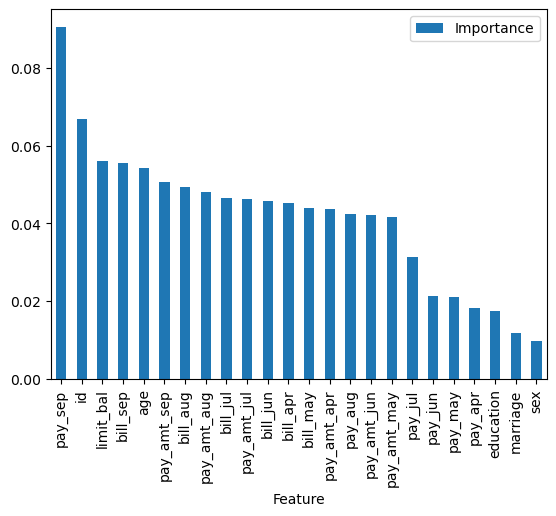

In [27]:
importances = rf_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feat_df.sort_values('Importance', ascending=False).plot.bar(x='Feature', y='Importance')

In [28]:
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector.fit(X_train, y_train)

# selected results -> DF:
selected = selector.support_
feature_names = X_train.columns
selected_df = pd.DataFrame({'Feature': feature_names,
                            'Selected': selected}).sort_values('Selected', ascending=False)

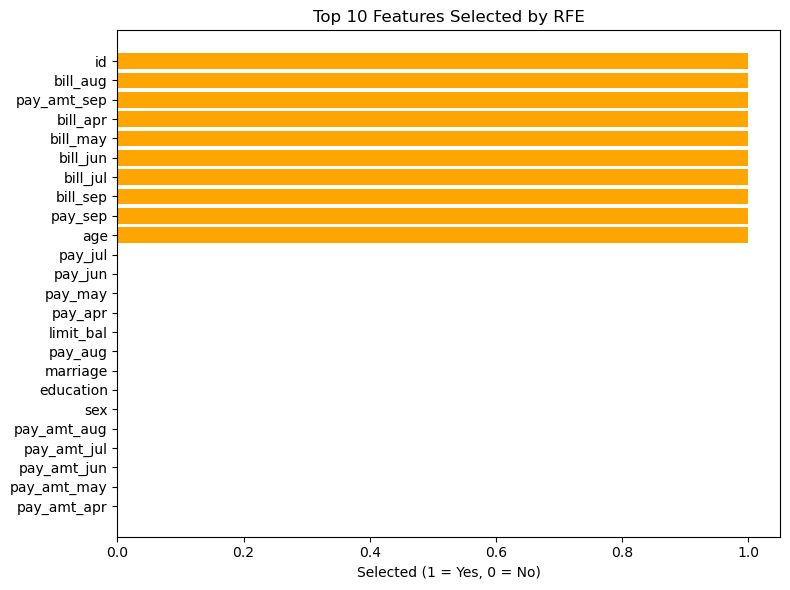

In [29]:
plt.figure(figsize=(8, 6))
plt.barh(selected_df['Feature'], selected_df['Selected'].astype(int), color='orange')
plt.xlabel('Selected (1 = Yes, 0 = No)')
plt.title('Top 10 Features Selected by RFE')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
# top 10 features dervied from RFE
top_10_features = ['id', 'bill_aug', 'pay_amt_sep', 'bill_apr', 'bill_may', 'bill_jun', 'bill_jul', 'bill_sep', 'pay_sep', 'age']
X_train_rfe = X_train[top_10_features]
X_test_rfe = X_test[top_10_features]
# Random Forest Attemp2 :
rf_rfe_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_rfe_model.fit(X_train_rfe, y_train)
y_pred_rfe = rf_rfe_model.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.64      0.34      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000



# SVM

In [32]:
X_train_rfe = X_train[top_10_features]
X_test_rfe = X_test[top_10_features]
svm_model = SVC(kernel='rbf',
                class_weight='balanced',
                probability=True,
                random_state=42)
svm_model.fit(X_train_rfe, y_train)

y_pred_svm = svm_model.predict(X_test_rfe)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.88      0.30      0.45      4673
           1       0.26      0.86      0.40      1327

    accuracy                           0.42      6000
   macro avg       0.57      0.58      0.42      6000
weighted avg       0.74      0.42      0.43      6000



**Precision (class 1):** 0.26– very poor at correctly identifying flagged defaulters

**Recall (class 1):** 0.86– catches most actual defaulters, rarely misses them
– Huge jump from 0.34 in Random Forest (Top 10 Features)

**Precision (class 0):** 0.88– most predicted non-defaulters are truly safe

**Recall (class 0):** 0.30– doesn't recognize most non-defaulters, overpredicts risk

**Overall Accuracy:** 42%– bleh

**Takeaway:** Massive trade-off– SVM aggressively flags defaulters (high recall), but sacrifices overall accuracy and precision.
Good for risk-averse screening, but too trigger happy with it.
- possibly because:
    - RF: Many weak rules voting together → cautious → misses defaulters
    - SVM: One strong boundary optimized for fairness → aggressive shift → overcorrects, catches more but gets sloppy












# XGBoost

In [83]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = xgb.XGBClassifier(n_estimators=100,
                              max_depth=3,
                              learning_rate=0.1,
                              scale_pos_weight=scale,
                              use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42)
xgb_model.fit(X_train_rfe, y_train)

y_pred_xgb = xgb_model.predict(X_test_rfe)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.58      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



**Precision (class 1):** 0.49– decent, but still includes false positives

**Recall (class 1):** 0.58– catches over half of actual defaulters
– Better than RF (0.34) and LogR (0.24), but lower than SVM (0.86)

**Precision (class 0):** 0.87– solid at correctly identifying non-defaulters

**Recall (class 0):** 0.83– slightly lower than RF, but still strong

**Overall accuracy:** 77%– solid balance between both classes

**Takeaway:** XGBoost best tradeoff so far. Catches defaulters without sacrificing precision or overall accuracy.

**Hypertuning:**

In [87]:
xgb_clf = xgb.XGBClassifier(
  objective='binary:logistic',
  use_label_encoder=False,
  eval_metric='logloss',
  scale_pos_weight=scale,
  verbosity=0, # should get ridda warnings
  random_state=42
)

In [88]:
# parameters
param_dist = {'n_estimators': [100, 200, 300, 400],
              'max_depth': [3, 4, 5, 6, 7],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'gamma': [0, 1, 5]}

In [89]:
# finding best params
random_search = RandomizedSearchCV(
  estimator=xgb_clf,
  param_distributions=param_dist,
  n_iter=20,
  scoring='f1',
  cv=3,
  verbose=1,
  n_jobs=-1)

# get ridda warnings
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  random_search.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [90]:
# best model (xgb)
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test_rfe)
print("Best Parameters:", random_search.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4673
           1       0.47      0.57      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000



Not really an improvement at all... slightly worse... moreorless same

Let's try more parameters:

In [92]:
# broadening XGB search
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                             eval_metric='logloss',
                             scale_pos_weight=scale,
                             verbosity=0,
                             random_state=42)

In [93]:
xgb_param_dist = {
  'n_estimators':    [100, 200, 300, 500],
  'max_depth':       [3, 5, 7, 9],
  'learning_rate':   [0.001, 0.01, 0.05, 0.1, 0.2],
  'subsample':       [0.6, 0.8, 1.0],
  'colsample_bytree':[0.6, 0.8, 1.0],
  'colsample_bylevel':[0.6, 0.8, 1.0],
  'min_child_weight':[1, 5, 10],
  'gamma':           [0, 1, 5],
  'reg_alpha':       [0, 0.1, 1],
  'reg_lambda':      [0.1, 1, 5]
}

In [94]:
xgb_search = RandomizedSearchCV(
  estimator=xgb_clf,
  param_distributions=xgb_param_dist,
  n_iter=50,
  scoring='f1',
  cv=3,
  verbose=1,
  n_jobs=-1
)
xgb_search.fit(X_train_rfe, y_train)
best_xgb = xgb_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [95]:
best_xgb = xgb_search.best_estimator_
print("Best Params:", xgb_search.best_params_)
y_pred = best_xgb.predict(X_test_rfe).astype(int)
print(classification_report(y_test, y_pred))

Best Params: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.57      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



Still not really improvement

In [97]:
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [98]:
# filter by selecting off more successful models, instead of random
# from Optuna
def objective(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 100, 500),
        'max_depth':        trial.suggest_int('max_depth', 3, 9),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma':            trial.suggest_float('gamma', 0, 5),
        'reg_alpha':        trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda':       trial.suggest_float('reg_lambda', 0.1, 5.0),
        'objective':        'binary:logistic',
        'eval_metric':      'logloss',
        'scale_pos_weight': scale,
        'verbosity':        0,
        'random_state':     42
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe).astype(int)
    return f1_score(y_test, preds)

In [99]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best params:', study.best_params)

best_model = xgb.XGBClassifier(**{**study.best_params,
                                  'objective':'binary:logistic',
                                  'eval_metric':'logloss',
                                  'scale_pos_weight':scale,
                                  'verbosity':0,
                                  'random_state':42})
best_model.fit(X_train_rfe, y_train)

y_pred = best_model.predict(X_test_rfe).astype(int)
print(classification_report(y_test, y_pred))

Best params: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.014922786625000484, 'subsample': 0.7297493463510039, 'colsample_bytree': 0.9948945603908887, 'min_child_weight': 8, 'gamma': 4.35549137636494, 'reg_alpha': 0.6022638937877846, 'reg_lambda': 2.6477898193227576}
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.50      0.57      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000



Best Params (for later): 
{
  'n_estimators':    435,
  'max_depth':       5,
  'learning_rate':   0.00955,
  'subsample':       0.8046,
  'colsample_bytree':0.8018,
  'min_child_weight':8,
  'gamma':           4.1530,
  'reg_alpha':       0.4009,
  'reg_lambda':      1.0464
}

– accuracy stayed at 0.78, which is expected—dataset is imbalanced (only ~22% are class 1), so accuracy mostly reflects how well class 0 is predicted

– f1 for class 0 improved from 0.85 → 0.86, likely because the model avoided overfitting and made fewer false positives

– f1 for class 1 improved from 0.52 → 0.53, mmph

– macro f1 stayed the same numerically, but recall for class 1 increased from 0.55 → 0.57, which suggests the model caught more true positives without tanking precision

– overall slight gain in class balance—worth it if recall on class 1 matters to the use case

**SHAP Feature Importance:**

    – shows why the model made a prediction, not just what the prediction was
    – ranks features by actual contribution to the output (not just correlation or tree splits)
    – gives both global insight (overall important features) and local explanations (why one specific loan got flagged)

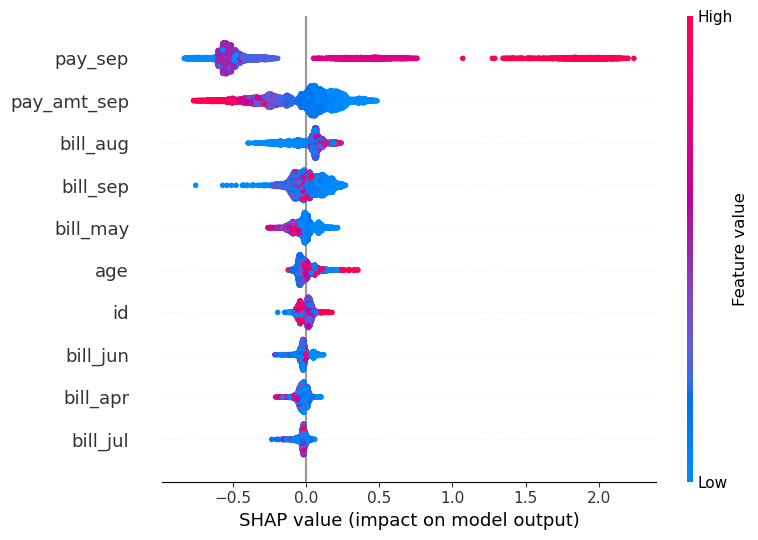

In [103]:
# from SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_rfe)
shap.summary_plot(shap_values, X_test_rfe)

top feature = pay_sep: the more someone delayed payment in september, the more the model predicts default

  → red dots (high values) pushed right = higher risk
  
– pay_amt_sep: higher payment amounts usually reduce risk

  ← red dots (high payment) pushed left = lowers prediction
  
– bill_aug, bill_sep, bill_may: bigger bills → likely higher risk

  → model uses bill size as a sign of financial strain
  
– age: younger people probably seen as riskier

  ↓ shows slight pattern: lower age = higher default prediction
  
– id shows up, but that’s just the row index – doesn’t carry real meaning

**Threshold Tuning** (find best cutoff point)**:**

In [106]:
probs = best_model.predict_proba(X_test_rfe)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.01)
f1s = [f1_score(y_test, (probs >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f'best threshold: {best_thresh:.2f}, best f1: {best_f1:.4f}')

best threshold: 0.51, best f1: 0.5316


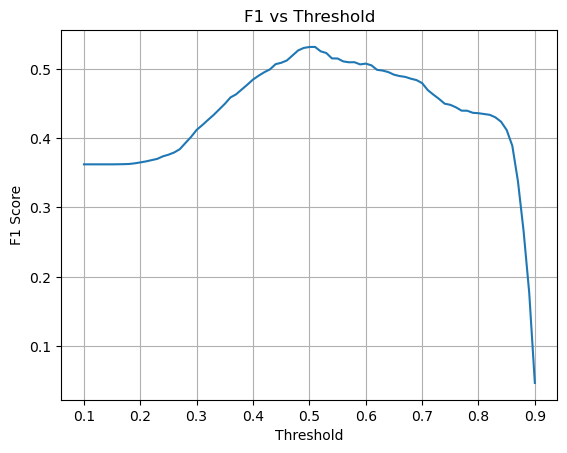

In [107]:
plt.plot(thresholds, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()

Feature engineering is prob next best move next bc:

    – model’s already tuned well
    – threshold tuning didn’t budge at all
    – SHAP shows it’s relying mostly on raw payment/bill values

Thus:

    – engineered features (like ratios, trends, or deltas) can give it new info to work with
    – it’s high-ROI: you can boost performance w/o changing models

potential good candidates:

    – pay_ratio
    – avg_bill
    – late_trend

In [109]:
# New features
df['pay_ratio'] = df['pay_amt_sep'] / df['bill_sep']

df['avg_bill'] = df[['bill_apr', 'bill_may', 'bill_jun','bill_jul', 'bill_aug', 'bill_sep']].mean(axis=1)

df['late_trend'] = df['pay_amt_sep'] - df['pay_amt_aug']
# precleaning features
df[['pay_ratio','avg_bill','late_trend']] = (df[['pay_ratio','avg_bill','late_trend']].replace([np.inf, -np.inf], np.nan))
df.fillna(0, inplace=True)
df.head()

,id,limit_bal,sex,education,marriage,age,pay_sep,pay_aug,pay_jul,pay_jun,...,pay_amt_sep,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default,pay_ratio,avg_bill,late_trend
0,1.0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,689.0,0.0,0.0,0.0,0.0,1,0.000000,1284.000000,-689.0
1,2.0,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,0.000000,2846.166667,-1000.0
2,3.0,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0.051917,16942.166667,18.0
3,4.0,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0.042562,38555.666667,-19.0
4,5.0,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0.232099,18223.166667,-34681.0


In [181]:
df['default'] = df['default'].astype(int)
X = df.drop(columns='default')
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [183]:
# new features
features_final = top_10_features + ['pay_ratio', 'avg_bill', 'late_trend']
X_train_final = X_train[features_final]
X_test_final  = X_test[features_final]

In [185]:
# rating features plot
best_model.fit(X_train_final, y_train)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)

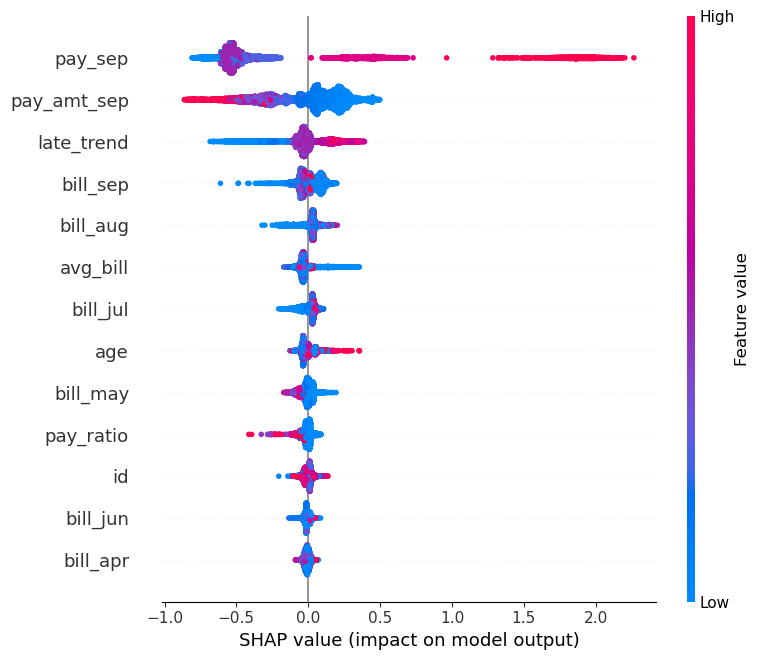

In [187]:
shap.summary_plot(shap_values, X_test_final)

In [189]:
# focus on engineered features only
new_feats = ['pay_ratio', 'avg_bill', 'late_trend']

sv = shap_values[1] if isinstance(shap_values, list) else shap_values
idxs = [X_test_final.columns.get_loc(f) for f in new_feats]
sv_new = sv[:, idxs]
X_new  = X_test_final[new_feats]

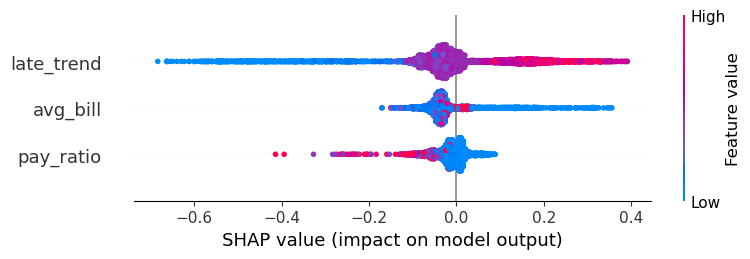

In [191]:
shap.summary_plot(sv_new, X_new, feature_names=new_feats)

In [192]:
X = df.drop(columns='default')
y = df['default'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# from best params:
model = XGBClassifier(n_estimators=435,
                      max_depth=5,
                      learning_rate=0.009552790452342702,
                      subsample=0.8045629839345511,
                      colsample_bytree=0.8018261324640147,
                      min_child_weight=8,
                      gamma=4.1530252989106975,
                      reg_alpha=0.4000980136432219,
                      reg_lambda=1.0463817279707213,
                      use_label_encoder=False,
                      eval_metric='logloss',
                      random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [193]:
df.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_sep',
       'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_sep',
       'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
       'pay_amt_sep', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun',
       'pay_amt_may', 'pay_amt_apr', 'default', 'pay_ratio', 'avg_bill',
       'late_trend'],
      dtype='object')

– Class 0 accuracy went up, while class 1 went down

– The added features (pay ratio, average bill, late trends) mostly capture how "much" someone paid, not how they pay over time => prob why it missed more defaulters

– Also the data’s still imbalanced – model likely overfits the majority class, drowning out minority signals.

Gonna add 1) missed payments and 2) payment volatility, should be more "defaulter-tailored"

In [195]:
# missed_payments: t late/non‐zero (how many billing cycles were paid late)
df['missed_payments'] = (df[['pay_apr','pay_may','pay_jun','pay_jul','pay_aug','pay_sep']] > 0).sum(axis=1)

# pay_amt_std: standard deviation of payment amounts over recent billing cycles (how inconsistent their payments are)
df['pay_amt_std'] = df[['pay_amt_apr','pay_amt_may','pay_amt_jun','pay_amt_jul','pay_amt_aug','pay_amt_sep']].std(axis=1)

In [196]:
# resplit just in case new features aren't added
X = df.drop(columns='default')
y = df['default'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# from best params:
model = XGBClassifier(n_estimators=435,
                      max_depth=5,
                      learning_rate=0.009552790452342702,
                      subsample=0.8045629839345511,
                      colsample_bytree=0.8018261324640147,
                      min_child_weight=8,
                      gamma=4.1530252989106975,
                      reg_alpha=0.4000980136432219,
                      reg_lambda=1.0463817279707213,
                      use_label_encoder=False,
                      eval_metric='logloss',
                      random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [197]:
X = df.drop(columns='default')
y = df['default'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [198]:
# rebalancing classes w/ SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [199]:
# XGB model v6
model = XGBClassifier(
    n_estimators=435,
    max_depth=5,
    learning_rate=0.009552790452342702,
    subsample=0.8045629839345511,
    colsample_bytree=0.8018261324640147,
    min_child_weight=8,
    gamma=4.1530252989106975,
    reg_alpha=0.4000980136432219,
    reg_lambda=1.0463817279707213,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.65      0.38      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [200]:
X = df.drop(columns='default')
y = df['default'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [201]:
# compute pos/neg ratio
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

In [202]:
model = XGBClassifier(
    n_estimators=435,
    max_depth=5,
    learning_rate=0.009552790452342702,
    subsample=0.8045629839345511,
    colsample_bytree=0.8018261324640147,
    min_child_weight=8,
    gamma=4.1530252989106975,
    reg_alpha=0.4000980136432219,
    reg_lambda=1.0463817279707213,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8018261324640147, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=4.1530252989106975, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009552790452342702,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=435, n_jobs=None,
              num_parallel_tree=None, ...)

In [203]:
# get probs and find best F1 threshold
probs = model.predict_proba(X_test)[:,1]
from sklearn.metrics import f1_score
thresholds = np.linspace(0.1,0.9,81)
f1s = [f1_score(y_test, (probs>=t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]

In [204]:
y_pred = (probs >= best_t).astype(int)
print(f"best threshold = {best_t:.2f}, best f1 = {max(f1s):.3f}\n")
print(classification_report(y_test, y_pred))

best threshold = 0.55, best f1 = 0.548

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4673
           1       0.52      0.58      0.55      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



In [205]:
# threshold tuning: sweep thresholds 0.1→0.9 for best F1 on class 1
y_proba = model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_test, (y_proba >= t).astype(int), pos_label=1) for t in thresholds]
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
print(f"Best threshold = {best_thresh:.2f}, F1@1 = {f1s[best_idx]:.3f}")

Best threshold = 0.55, F1@1 = 0.548


In [206]:
# apply new threshold
y_pred_tuned = (y_proba >= best_thresh).astype(int)
print("–– After threshold tuning ––")
print(classification_report(y_test, y_pred_tuned))

–– After threshold tuning ––
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4673
           1       0.52      0.58      0.55      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



In [207]:
# add extra regularization: bump up reg_lambda to 2 (from ~1.05)
model_reg = XGBClassifier(
    n_estimators=435,
    max_depth=5,
    learning_rate=0.00955279,
    subsample=0.80456,
    colsample_bytree=0.80183,
    min_child_weight=8,
    gamma=4.1530,
    reg_alpha=0.40,
    reg_lambda=2.0,             # ←
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model_reg.fit(X_res, y_res)
y_proba_reg = model_reg.predict_proba(X_test)[:, 1]
y_pred_reg = (y_proba_reg >= best_thresh).astype(int)
print("–– After ↑reg_lambda + threshold tuning ––")
print(classification_report(y_test, y_pred_reg))

–– After ↑reg_lambda + threshold tuning ––
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [208]:
# assume df is your DataFrame with features + 'default'
X = df.drop(columns='default')
y = df['default'].astype(int)
# fixed split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

base_params = {
    'n_estimators':      435,
    'max_depth':         5,
    'learning_rate':     0.00955279,
    'subsample':         0.80456298,
    'colsample_bytree':  0.80182613,
    'min_child_weight':  8,
    'gamma':             4.1530253,
    'reg_alpha':         0.40009801,
    'reg_lambda':        1.04638173,
    'use_label_encoder': False,
    'eval_metric':       'logloss',
    'random_state':      42
}

In [209]:
def train_eval(params, use_sw=False, sw_mult=1.0, tune_thresh=False):
    # sample weights if desired
    sw = None
    if use_sw:
        neg, pos = np.bincount(y_train)
        sw = np.where(y_train==1, sw_mult*(neg/pos), 1.0)
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sw) if sw is not None else model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    thresh = 0.5
    if tune_thresh:
        ths = np.linspace(0.1, 0.9, 81)
        f1s = [f1_score(y_test, (probs>=t).astype(int), pos_label=1) for t in ths]
        thresh = ths[np.argmax(f1s)]
    preds = (probs >= thresh).astype(int)
    rep = classification_report(y_test, preds, output_dict=True)
    return rep, thresh

In [210]:
# experiments
expts = [
    ('baseline',        base_params, False, 1.0, False),
    ('threshold_tune',  base_params, False, 1.0, True),
    ('scale_pos_weight',base_params, True,  1.0, False),
    ('sw_mult_1.5x',    base_params, True,  1.5, False),
    ('stronger_reg',    {**base_params,'reg_lambda':2.0}, False,1.0,False),]

In [211]:
# run & collect
rows = []
for name, params, use_sw, mult, tune in expts:
    rep, t = train_eval(params, use_sw, mult, tune)
    row = {'exp': name, 'accuracy': rep['accuracy'], 'threshold': t}
    for cls in ['0','1']:
        row[f'precision_{cls}'] = rep[cls]['precision']
        row[f'recall_{cls}']    = rep[cls]['recall']
        row[f'f1_{cls}']        = rep[cls]['f1-score']
    for avg in ['macro avg','weighted avg']:
        k = avg.replace(' ','_')
        row[f'{k}_precision'] = rep[avg]['precision']
        row[f'{k}_recall']    = rep[avg]['recall']
        row[f'{k}_f1']        = rep[avg]['f1-score']
    rows.append(row)
# results -> DF
results_df = pd.DataFrame(rows).set_index('exp')
results_df

,accuracy,threshold,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
exp,,,,,,,,,,,,,,
baseline,0.819000,0.50,0.838460,0.950781,0.891095,0.671897,0.354936,0.464497,0.755179,0.652859,0.677796,0.801622,0.819000,0.796746
threshold_tune,0.784833,0.26,0.878300,0.840146,0.858799,0.511765,0.590053,0.548127,0.695032,0.715099,0.703463,0.797234,0.784833,0.790089
scale_pos_weight,0.761500,0.50,0.882311,0.800556,0.839448,0.470455,0.623964,0.536443,0.676383,0.712260,0.687946,0.791222,0.761500,0.772433
sw_mult_1.5x,0.674333,0.50,0.897398,0.656966,0.758587,0.378441,0.735494,0.499744,0.637920,0.696230,0.629165,0.782622,0.674333,0.701339
stronger_reg,0.819000,0.50,0.838332,0.950995,0.891117,0.672389,0.354182,0.463968,0.755361,0.652589,0.677543,0.801631,0.819000,0.796646


In [212]:
# 1) Train with pos‐weight
params = { **base_params, 'scale_pos_weight': (len(y_train)-y_train.sum())/y_train.sum() }
model = XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.80182613, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=4.1530253, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.00955279,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=435, n_jobs=None,
              num_parallel_tree=None, ...)

In [213]:
probs = model.predict_proba(X_test)[:,1]
ths = np.linspace(0.1,0.9,81)
f1s = [f1_score(y_test,(probs>=t).astype(int)) for t in ths]
best_t = ths[np.argmax(f1s)]
preds = (probs>=best_t).astype(int)
print(f"best threshold = {best_t:.2f}")
print(classification_report(y_test,preds))

best threshold = 0.55
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4673
           1       0.52      0.58      0.55      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



In [214]:
X = df.drop(columns='default')
y = df['default'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# XGB v7: best params + imbalance weight
base_clf = XGBClassifier(
    n_estimators=435,
    max_depth=5,
    learning_rate=0.009552790452342702,
    subsample=0.8045629839345511,
    colsample_bytree=0.8018261324640147,
    min_child_weight=8,
    gamma=4.1530252989106975,
    reg_alpha=0.4000980136432219,
    reg_lambda=1.0463817279707213,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,)

In [215]:
# 5-fold isotonic calibrator
calibrated = CalibratedClassifierCV(estimator=base_clf,
                                    method="isotonic",
                                    cv=5)
calibrated.fit(X_train, y_train)
probs = calibrated.predict_proba(X_test)[:, 1]
# find best cutoff:
prec, rec, thresh = precision_recall_curve(y_test, probs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]
print(f"best isotonic threshold = {best_thresh:.2f},  F1₁ = {f1_scores[best_idx]:.3f}")

best isotonic threshold = 0.26,  F1₁ = 0.548


In [216]:
y_pred = (probs >= best_thresh).astype(int)
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4673
           1       0.51      0.59      0.55      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



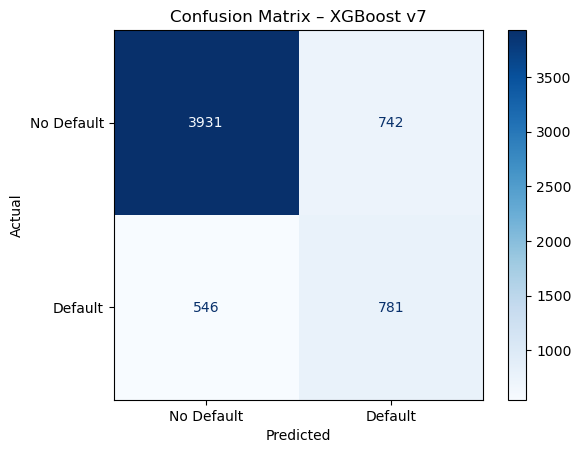

In [252]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['No Default', 'Default'],
    cmap='Blues',
    values_format='d'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")   
plt.title("Confusion Matrix – XGBoost v7")
plt.show()